[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dapivei/causal-infere/blob/main/sections/5_Experiments.ipynb)

# Experiments (Cont.)

## Recap From Last Class
- A final review of Statistics
- An introduction to Randomized Controlled Trials (RCTs): **identifying our ATE**.

## Goals for today



Continuing with RCTs:
- **The measurement of our ATE**: estimating causal quantities from sample data.
- **Interpreting our ATE**: How do we map from the quantities that we estimate to the quantities we care about? How do we assess confidence in the estimated causal quantities.
- Implications of relaxing the SUTVA and perfect compliance assumptions.
- Potential pitfalls of RCTs.

Support for Homework 2:
- Review sampling distributions and the Central Limit Theorem (CLT) using Python.


## Estimating Causal Effects from Sample Data

The fundamental principle of randomization is straightforward:

> When units are randomly assigned to a treatment, the only distinction between those receiving the treatment and those who do not is the treatment itself. Consequently, any observed differences between the two groups can be attributed solely to the treatment.

Our objective is to estimate the **Average Treatment Effect (ATE)**, which measures the difference in outcomes between individuals who received a treatment and those who did not.

To do this, we rely on two key assumptions: **perfect compliance** and **SUTVA**, which allows us to assert that the treatment, $S$, is **independent** of other factors, $U$, that could influence the outcome $Y$, leading to:

$$
ATE = \mathbb{E}[Y(S=1, U) \mid S=1] - \mathbb{E}[Y(S=0, U) \mid S=0].
$$

Let's apply these concepts to estimate the ATE from the case study we introduced last section:

> the impact of a job training program ($S$), National Supported Work (NSW) Demonstration, on wages ($Y$).

Participants were _randomly assigned_ to receive job training or not, which helped ensured independence from confounding factors.




Our goal is to replicate the estimation conducted by LaLonde, who utilized data from the randomized evaluation to assess the program's effectiveness. For more detailed information about the study anda data, refer to the following resource: [LaLonde's Study](https://search.r-project.org/CRAN/refmans/designmatch/html/lalonde.html).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Digraph
from tabulate import tabulate
from scipy import stats
from statsmodels.formula.api import ols

In [2]:
url_base = '../data/nsw.dta'
data = pd.read_stata(url_base)




### Causal Model for the Impact of the Job Training Program on Wages

Some key components of this causal model are:

- **Treatment Indicator ($S$)**: A binary variable, denoted as $\text{treat}$, which indicates whether an individual received job training (1) or not (0).

- **Outcome ($Y$)**: The primary outcome of interest, represented as $\text{re78}$, to indicate the annual wages of participants measured in the year 1978.

- **Confounding Variables ($U$)**: Other factors that may affect wages include age, education, race, marital status, and degree.


In [3]:
data.describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000
mean,0.411357,24.520776,10.267313,0.800554,0.105263,0.162050,0.779778,3042.896484,5454.635742
std,0.492421,6.625947,1.704774,0.399861,0.307105,0.368752,0.414683,5066.143066,6252.943359
min,0.000000,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,936.307953,3951.889038
75%,1.000000,27.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3993.206970,8772.004395
max,1.000000,55.000000,16.000000,1.000000,1.000000,1.000000,1.000000,37431.660156,60307.929688


According to our data, the study included 722 participants, with 425 receiving the job training program.

In [4]:
data['treat'].value_counts()

treat
0    425
1    297
Name: count, dtype: int64

### 2.2) $\hat{ATE}$?

To estimate the ATE from data, we calculate the **conditional sample means**:

$$
\hat{ATE} = \mathbb{\hat{E}}[Y(1, \hat{U}) \mid S = 1] - \mathbb{\hat{E}}[Y(0, \hat{U}) \mid S = 0].
$$

Since these sample means are **consistent** and **unbiased**, our estimate of the ATE is robust and reliable.

Therefore, to estimate the ATE of the job training program ($S$) on wages ($Y$), we would simply:

In [5]:
# Conditional samples means for treated and control groups
mean_treated = data[data['treat']==1]['re78'].mean()
mean_control = data[data['treat']==0]['re78'].mean()
# ATE as the difference in conditional means
ate = mean_treated - mean_control
print(f"Estimated ATE (Difference in Means): {ate:.2f}")

Estimated ATE (Difference in Means): 886.30


This implies, that, on average, individuals who received the job training program earned $886.30$ than those who did not receive the training. **How confident are we on these results?**

### 2.3) How confidente are we on our $\hat{ATE}$?


This is only an estimate of the ATE, and we cannot be certain it reflects the true value. Fortunately, the Central Limit Theorem (CLT) allows us to approximate the distribution of errors in the estimated conditional sample means.

#### Hypothesis Testing for the ATE

To determine whether the work program has a positive impact on wages, our hypothesis is as follows:

- **Null Hypothesis ($H_0$)**:
$$\mathbb{E}[Y(S = 1, U)] = \mathbb{E}[Y(S = 0, U)] \implies \text{ATE}=0.$$


- **Alternative Hypothesis ($H_1$)**: $$  \mathbb{E}[Y(S = 1, U)] >  \mathbb{E}[Y(S = 0, U)] \implies \text{ATE}>0.$$



Notice that we’re doing a one-sided test!

In [6]:
income_treate = data[data['treat']==1].re78
income_contro = data[data['treat']==0].re78

stats.ttest_ind(
    income_treate,
    income_contro,
    alternative='greater',
    equal_var=False
    )


TtestResult(statistic=np.float64(1.8154352445974968), pvalue=np.float64(0.034997297522789676), df=np.float64(557.0617000675076))

Since the p-value is approximately 0.035, which is less than the common significance level of 0.05, we reject the null hypothesis. This implies that there is statistically significant evidence to support the claim that the mean income of the treated group is greater than that of the control group.

### 2.4) Testing our Assumptions

So far we have relied on a crucial assumption: $$S \perp\!\!\!\perp U.$$

This assumption is supported by:

**a) perfect compliance**, our assumption that all participants adhere to their assigned treatments, and

In [7]:
gr_per = Digraph(format="png", graph_attr={"rankdir": "LR", "size": "8"})
gr_per.node("Z", label="Z: Assignment")
gr_per.node("S", label="S: Treatment Received")
gr_per.node("Y", label="Y: Outcome")
gr_per.edge("Z", "S", label="Compliance")
gr_per.edge("S", "Y", label="Treatment Effect")


**b) stable unit treatment value assumption (SUTVA)**, which ensures that potential outcomes for each participant are unaffected by the treatment assignments of others.

Together, these principles are essential for obtaining valid and unbiased estimates of the ATE. **Can we test these assumptions?**


**Testing for these assumptions in a RCT is hard!** Some effective methods researchers use to assess these assumptions are:
+ direct monitoring: self-reports or observation.
+ biomarkers or biological test

## $S \perp\!\!\!\perp U$

Independence between $S$ and $U$ implies that the distribution of potential outcomes $Y$ given treatment status is the same across groups:

$$
P(Y \mid S=1, U) = P(Y \mid S=0, U).
$$

A crucial implication of this independence is that the treatment and control groups should exhibit similarity in their characteristics:

$$
P(U \mid S=1) = P(U \mid S=0).
$$

Thus, any observed differences in outcomes can be attributed to the treatment $S$, rather than confounding factors $U $.


To assess this, we can compare the observable characteristics of the treatment and control groups. A first step is to visually examine the observable characteristics of both groups in the experiment.

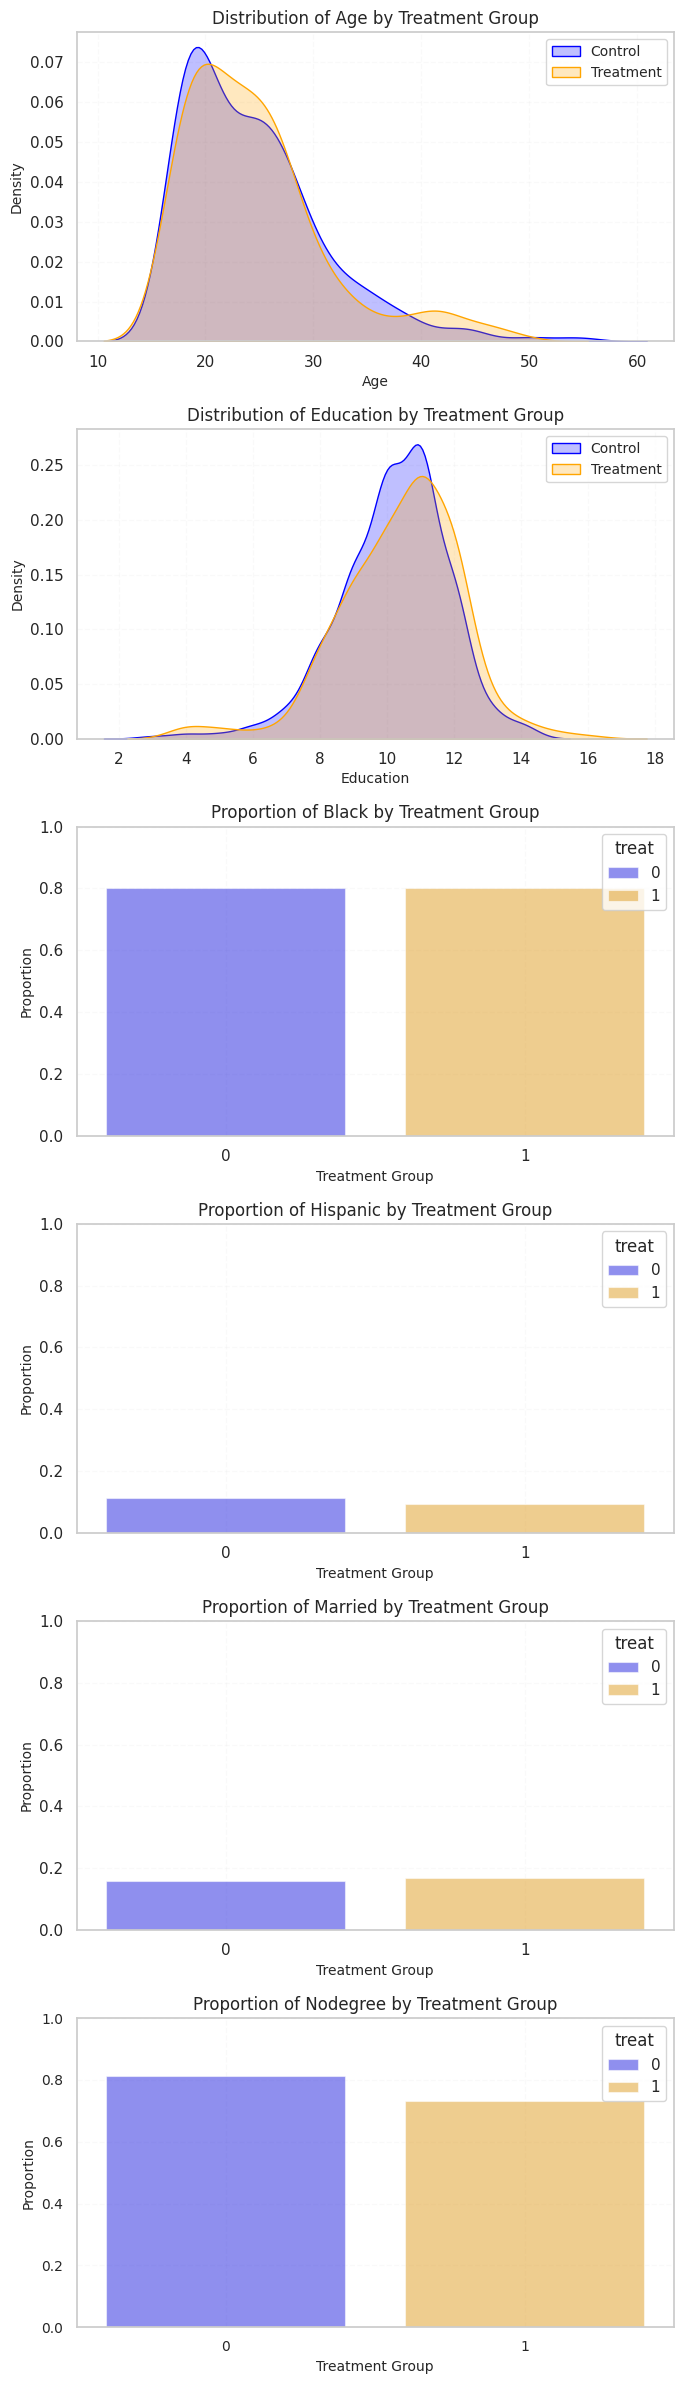

In [8]:
continuous_covariates = ['age', 'education']
dummy_covariates = ['black', 'hispanic', 'married', 'nodegree']
covariates = continuous_covariates + dummy_covariates

sns.set(style='whitegrid', palette='deep')
total_covariates = len(continuous_covariates) + len(dummy_covariates)
fig, axes = plt.subplots(nrows=total_covariates, ncols=1, figsize=(7, total_covariates * 4))

for i, var in enumerate(continuous_covariates):
    sns.kdeplot(data[data['treat'] == 0][var], ax=axes[i], label="Control", fill=True, color='blue')
    sns.kdeplot(data[data['treat'] == 1][var], ax=axes[i], label="Treatment", fill=True, color='orange')
    axes[i].set_title(f'Distribution of {var.capitalize()} by Treatment Group', fontsize=12)
    axes[i].set_xlabel(var.capitalize(), fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.1)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

for j, var in enumerate(dummy_covariates, start=len(continuous_covariates)):
    proportions = data.groupby('treat')[var].mean().reset_index()
    sns.barplot(
        x='treat',
        y=var, data=proportions, ax=axes[j],
        hue='treat', dodge=False,
        palette=['blue', 'orange'], linewidth=0.8, alpha=0.5
        )
    axes[j].set_title(f'Proportion of {var.capitalize()} by Treatment Group', fontsize=12)
    axes[j].set_xlabel('Treatment Group', fontsize=10)
    axes[j].set_ylabel('Proportion', fontsize=10)
    axes[j].set_ylim(0, 1)
    axes[j].grid(True, linestyle='--', alpha=0.1)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


Inspecting the distributions of key variables (e.g., age, marital status, education level, etc.) reveals that the distributions for both the treatment and control groups have similar shapes, signaling that the groups are well-balanced in terms of observable characteristics.

Next, we can formally test that our groups are indeed "well balanced" by conducting a **balance test**! This test compares the distributions of an observable covariate $X$ between the treatment group $S = 1$ and the control group $S = 0$.

Our balance test is a two-sample t-test to determine whether the difference in means is statistically significant:
$$ H_0: \mathbb{E}(X | S = 1) = \mathbb{E}(X | S = 0), \quad H_a: \mathbb{E}(X | S = 1) \neq \mathbb{E}(X | S = 0)
$$

+ $H_0$ states that there is no difference in the means of the observable covariate between the treatment and control groups.
+ $H_a$ states that there is a difference in means.


We conclude that $S \perp U$ if the means of the observables are not statistically significantly different.

Let's see how this test can be conducted using the Lalonde experiment:

In [9]:
balance_results = []
for var in covariates:
    control_group = data[data['treat'] == 0][var]
    treatment_group = data[data['treat'] == 1][var]
    control_mean, control_std = control_group.mean(), control_group.std()
    treatment_mean, treatment_std = treatment_group.mean(), treatment_group.std()
    t_stat, p_value = stats.ttest_ind(control_group, treatment_group, equal_var=False)
    pooled_std = np.sqrt((control_std ** 2 + treatment_std ** 2) / 2)
    smd = (treatment_mean - control_mean) / pooled_std
    balance_results.append({
        'Variable': var,
        'Control Mean (SD)': f'{control_mean:.2f} ({control_std:.2f})',
        'Treatment Mean (SD)': f'{treatment_mean:.2f} ({treatment_std:.2f})',
        'SMD': smd,
        'P-Value': p_value
    })
balance_table = pd.DataFrame(balance_results)

 Notice we compare the mean values of each covariate between the control and treatment groups using a t-test to evaluate the null hypothesis. If the p-value exceeds the significance level (e.g., $\alpha = 0.05$), we fail to reject the null hypothesis, suggesting that the means are not significantly different.

In [10]:
balance_table

,Variable,Control Mean (SD),Treatment Mean (SD),SMD,P-Value
0,age,24.45 (6.59),24.63 (6.69),0.026995,0.721607
1,education,10.19 (1.62),10.38 (1.82),0.111695,0.144283
2,black,0.80 (0.40),0.80 (0.40),0.003366,0.964504
3,hispanic,0.11 (0.32),0.09 (0.29),-0.061189,0.415479
4,married,0.16 (0.36),0.17 (0.37),0.028938,0.702799
5,nodegree,0.81 (0.39),0.73 (0.44),-0.199791,0.009247


> **How do we interpret this balance table?**
Consider the first t-test, where $X=age$:
   - The average age of individuals in the control group is **24.45 years** with a standard deviation of **6.59 years**.The average age of individuals in the treatment group is **24.63 years** with a standard deviation of **6.69 years**.
   - An SMD of **0.027** indicates that the difference between the control and treatment groups in terms of age is very small (close to zero). Generally, SMD values below **0.1** are considered to indicate good balance between groups.
   - The p-value from the t-test is **0.722**, which is much greater than the common significance level of **0.05**. This means we **fail to reject the null hypothesis**, indicating that there is **no statistically significant difference** in the mean age between the control and treatment groups.

We can further visualize the SMD through a plot:

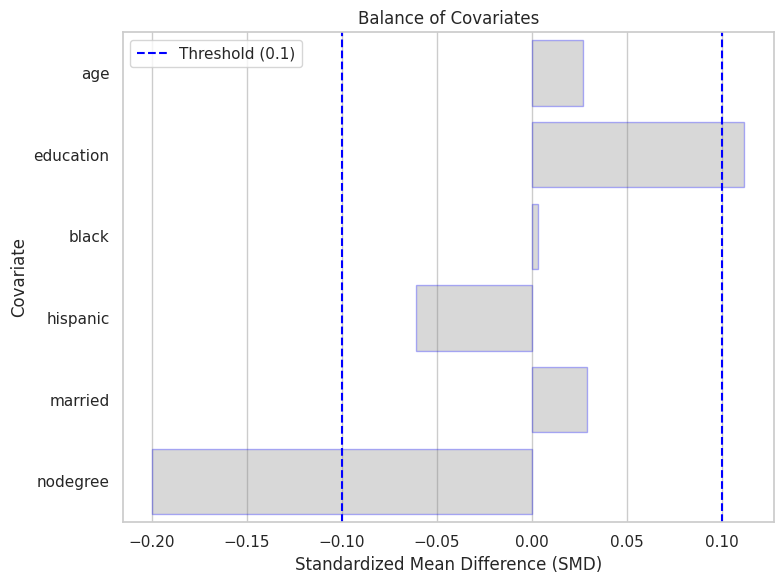

In [11]:
sns.set(style='whitegrid', palette='deep')
smd_df = balance_table[['Variable', 'SMD']].rename(columns={'Variable': 'Covariate'})
plt.figure(figsize=(8, 6))
sns.barplot(x='SMD', y='Covariate', data=smd_df, color='gray', alpha=0.3, edgecolor='blue')
plt.axvline(x=0.1, color='blue', linestyle='--', label='Threshold (0.1)')
plt.axvline(x=-0.1, color='blue', linestyle='--')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.ylabel('Covariate')
plt.title('Balance of Covariates')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Relaxing Assumptions: Imperfect Compliance and SUTVA Violations

**What if we relaxed our assumptions of perfect compliance and SUTVA? When and why might these violations occur?**

+ Imperfect compliance can occur due to non-adherence, cross-over, dropouts, or other practical challenges in real-world implementation.

+ SUTVA violations may arise from interference between participants, different versions of the treatment, or external contamination of the control group.

Such violations complicate causal effect estimation, potentially shifting our target parameters or requiring alternative techniques to adjust for these issues.

### 3.1. Imperfect Compliance
Perfect compliance is rarely observed in real-world scenarios, making it reasonable to assume imperfect compliance. This means that not all individuals adhere to their assigned treatment ($S$), which can introduce bias when estimating the causal effect.






In [12]:
gr_imp = Digraph(format="png", graph_attr={"rankdir": "LR", "size": "8"})
gr_imp.node("Z", label="Z: Assignment", pos="0,0!")
gr_imp.node("S", label="S: Treatment", pos="1,0!")
gr_imp.node("Y", label="Y: Outcome", pos="2,0!")
gr_imp.node("U", label="U: Confounder")
gr_imp.edge("Z", "S")
gr_imp.edge("S", "Y")
gr_imp.edge("U", "S", constraint="false")
gr_imp.edge("U", "Y", constraint="false")

In [13]:
# Perfect compliance
gr_per

Under perfect compliance, we expect $P(Z) = P(S)$. When compliance is imperfect, however, $P(Z) \neq P(S)$, as some individuals may not adhere to their assigned treatment. This discrepancy complicates causal inference, especially when unobserved variables ($U$) influence both the treatment received ($S$) and the outcome ($Y$), creating confounding.

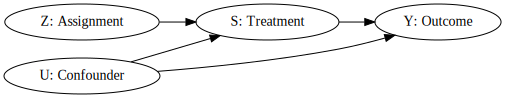

In [14]:
# Imperfect compliance
gr_imp

To address imperfect compliance, we can employ several methods:

- **Local Average Treatment Effect (LATE)**: Uses instrumental variable techniques to estimate causal effects among compliers (we will cover this later).
- **Bounding Methods**: Establishes bounds on treatment effects when compliance is imperfect.
- **Redefining the Target Parameter**: Adjusts the focus of the analysis to reflect the realities of non-compliance.

For now, we will focus on redefining our parameter of interest from ATE to **Intention to Treat (ITT)**, which measures the causal effect of **being assigned** to treatment, regardless of whether the treatment was actually received.

Let’s revisit the example we previously discussed regarding a job training program ($S$) and its impact on participants' wages ($Y$). Initially, we observed that **~59% of the individuals** received the job training program, while **~41% of the individuals did not**.

In [15]:
data.treat.value_counts(normalize=True) * 100

treat
0    58.864266
1    41.135734
Name: proportion, dtype: float64

Imagine a twist in the narrative: **It is later revealed that the original design of the study assigned 50% of the sample to the treatment group.**

However, we have recently observed that not all participants adhered to their assigned groups.

In [16]:
np.random.seed(42)
desired_treatment_proportion = 0.5
n = len(data)
n_treatment_assigned = int(n * desired_treatment_proportion)
assignment = np.zeros(n)
assignment[:n_treatment_assigned] = 1
np.random.shuffle(assignment)
data['assign'] = assignment
data[['assign', 'treat']].value_counts()

assign  treat
0.0     0        225
1.0     0        200
        1        161
0.0     1        136
Name: count, dtype: int64

This discrepancy raises significant questions about the validity of the study's findings and complicates the interpretation of the treatment's effectiveness! **What could we do**?

**Why would non-compliance occur?**  More importantly, should we reconsider our target parameter? **Why?**

Perhaps, it might be more appropiate to calculate the ITT for the job training program, where:

- $S_A = 1$ if an individual is assigned to receive the job training program (told to participate).
- $S_A = 0$ if an individual is not assigned to receive the training.
- $Y(S_A, U)$ represents the outcome variable, which in this case is the wage of participants one month after the assignment.
- $U$ captures all other factors that influence wages.

The ITT is defined as:

$$
ITT = \mathbb{E}[Y(S_A = 1, U)] - \mathbb{E}[Y(S_A = 0, U)].
$$

In [17]:
mean_itt_treated = data[data['assign'] == 1]['re78'].mean()
mean_itt_control = data[data['assign'] == 0]['re78'].mean()
itt = mean_itt_treated - mean_itt_control
print(f"Estimated ITT: {itt:.2f}")

Estimated ITT: 833.30


This is the average effect **of being assigned** to the job training program on wages, while holding constant all other determinants captured by $U$. Would this approach be useful for policymakers assessing the program's potential benefits in a real-world setting?




### SUTVA violation

SUTVA implies two conditions:
1. No interference between units.-  The treatment of one unit doesn't affect another unit.
2. Consistency.- Each unit has a single potential outcome under each treatment condition.

SUTVA violation occurs when the no interference assumption does not hold. This is known as a **spillover** effect, which means the

> treatment effect _spills over_ to others who weren't treated.

Spillovers make it hard to estimate the _pure effect_ of treatment because the control group may still be affected by the treatment due to interactions with treated units.

      T_1         T_2        T_3        T_4
       |           |          |          |
     Y_1 <-----  Y_2 <----- Y_3 ------ Y_4



Consider the graph above, where we have different treatment groups represented by $T_1, T_2, T_3, T_4$ and their corresponding outcomes represented by $Y_1, Y_2, Y_3, Y_4$.

+ Notice the arrows in the graph indicate that the outcomes are interconnected in a way that violates the SUTVA assumption. This means we cannot cleanly separate treated and untreated outcomes, which complicates our estimates. **How do we handle spillovers?**


Suppose we are interested in understanding the impact of tutoring programs. Say we randomly assign some students to receive tutoring (the treatment). **Would we be able to identify  ATE?**

This experiment would presumably fail! Why? Spillover effects are highly likely as knowledge gained by treated students could positively influence untreated peers due to peer interactions.

**How could we manage spillover effects?** We can randomize entire classrooms or schools to either receive the tutoring intervention or not. Meaning, given that $S_G \perp\!\!\!\perp U $, where $S_G$ denotes the group-level treatment and $ U$ represents unobserved confounders, we have:

   $$
   \text{ATE}_G = \mathbb{E}[Y_G(S_G = 1, U_G) | S_G = 1] - \mathbb{E}[Y_G(S_G = 0, U_G) | S_G = 0],
   $$

   where $Y_G$ is the school-level outcome.
   
   This approach enables us to estimate the average treatment effect (ATE) at the group level by comparing outcomes between treated and untreated groups, capturing both the treatment and spillover effects.

In [18]:
np.random.seed(42)
n_schools = 20
students_per_school = 30
school_ids = np.arange(n_schools)
treatment_assignment = np.zeros(n_schools)
num_treated = np.random.randint(10, 15)
treated_schools = np.random.choice(school_ids, size=num_treated, replace=False)
treatment_assignment[treated_schools] = 1
school_data = pd.DataFrame({
    'school_id': school_ids,
    'treat': treatment_assignment
})

In [19]:
def simulate_group_outcome(treatment):
    np.random.seed(42)
    base_outcome = 50  # Base score
    return base_outcome + treatment * np.random.normal(10, 5)  # Adding treatment effect

In [20]:
school_data['mean_outcome'] = school_data['treat'].apply(simulate_group_outcome)

In [21]:
school_data

,school_id,treat,mean_outcome
0,0,1.0,62.483571
1,1,1.0,62.483571
2,2,0.0,50.000000
3,3,1.0,62.483571
4,4,1.0,62.483571
5,5,1.0,62.483571
6,6,0.0,50.000000
7,7,0.0,50.000000
8,8,1.0,62.483571
9,9,0.0,50.000000


In [22]:
mean_ate_treated_g = school_data[school_data['treat'] == 1]['mean_outcome'].mean()
mean_ate_control_g = school_data[school_data['treat'] == 0]['mean_outcome'].mean()
ate_g = mean_ate_treated_g - mean_ate_control_g
print(f"Estimated ATE_g: {ate_g:.2f}")

Estimated ATE_g: 12.48



Notice the contrast when assigning treatment at the individual level, where we estimate the ATE based on the differences in outcomes between individuals assigned to treatment and control.



### RCTs: The Gold Standard? A Side Note on Their Limitations

RCTs are often seen as the gold standard in research due to their high internal validity. However, they have significant limitations:

- Ethical Concerns
- Limited Generalizability
- Attrition Bias
- Variability in Implementation
- Sample Size Issues
- Cost and Time Constraints
- Hawthorne Effect

A key example is the debate over Miguel and Kremer's (2004) deworming study (reviews in class), which demonstrated strong effects on worm infections and school attendance.

Critics have questioned the validity of Miguel and Kremer's (2004) findings, citing the Hawthorne effect, where participants' behavior may have been influenced simply by their awareness of being observed.



## Recap on sampling distributions and the Central Limit Theorem (CLT) on Python -- HELP FOR HOMEWORK!

When we want to sample from a **uniform distribution**, we're interested in generating random values that have an equal likelihood of falling anywhere within a specified interval. This can be accomplished using the NumPy library in Python.

In [23]:
# For reproducibility
np.random.seed(42)

To draw samples from a uniform distribution, we can use the following function:

```python
np.random.uniform(low, high, size)
```

**Parameters**:
  - `low`: The lower bound of the interval (inclusive).
  - `high`: The upper bound of the interval (exclusive).
  - `size`: This parameter specifies the shape of the output array.

Note that samples are drawn from the half-open interval: $$[\text{low}, \text{high}).$$

Say we want to generate samples uniformly distributed over $[-1, 1]$. To include 1 in the upper bound, we can add a small value, called **epsilon**, which is the smallest representable positive number such that \(1 + \text{epsilon}\) is greater than $1$.

```python
np.random.uniform(-1, 1 + np.finfo(float).eps, size)
```

Lastly, the `size=(num_samples, n)` parameter can be a tuple to define the shape of the generated array.

- **`num_samples`**: This represents the number of independent samples or trials we want to generate.
- **`n`**: This is the number of random values (the sample size) in each trial.

In [24]:
# Generate samples
num_samples, n = 10, 5
samples = np.random.uniform(-1, 1 + np.finfo(float).eps, (num_samples, n))

In [25]:
len(samples)

10

In [26]:
samples[0]

array([-0.25091976,  0.90142861,  0.46398788,  0.19731697, -0.68796272])

In [27]:
# Compute sample means
sample_means = np.mean(samples, axis=1)
print(sample_means)

[ 0.1247702  -0.04422325 -0.11315957 -0.30576906 -0.25363071 -0.14482033
  0.10305526 -0.0659725  -0.27211838 -0.10965355]


In [28]:
# Proportion of the sample means lie within the range [-0.1,0.1]
proportion = np.mean((sample_means >= -0.1) & (sample_means <= 0.1))
print(f"Proportion of the sample means lie within the range [-0.1,0.1]:", {proportion})

Proportion of the sample means lie within the range [-0.1,0.1]: {np.float64(0.2)}


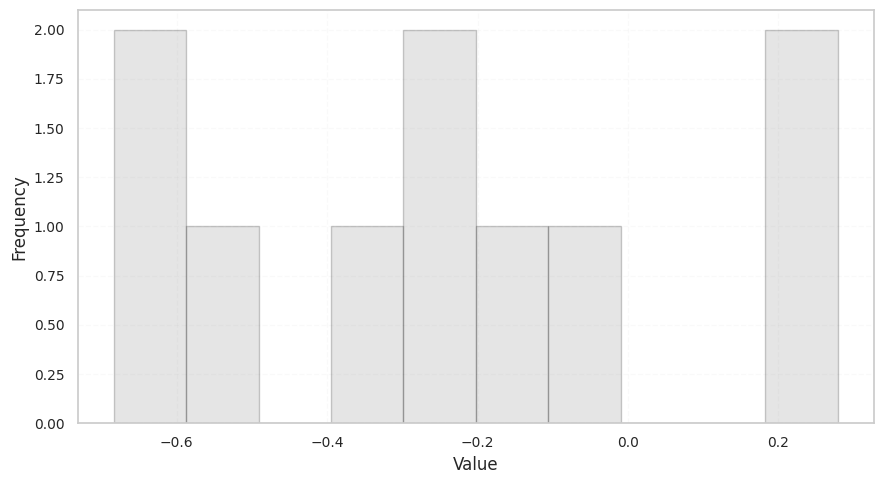

In [29]:
sns.set(style='whitegrid', palette='deep')
plt.figure(figsize=(9, 5))
plt.hist(sample_means * np.sqrt(n), bins=10, color='grey', edgecolor='black', alpha=0.2)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.1)
plt.tight_layout()
plt.show()

## 5. Path Forward

+ Advanced causal inference methods, e.g., regression, natural experiments, etc.

---

**References:**


+ Lalonde, R. J. (1986). *Evaluating the Econometric Evaluations of Training Programs with Experimental Data.* American Economic Review, 76(4), 604-620.

+ Athey, S., Chetty, R., & Imbens, G. W. (2020). Combining Experimental and Observational Data to Estimate Treatment Effects on Long-Term Outcomes. [https://arxiv.org/pdf/2006.09676]

+ Miguel, Edward and Michael Kremer. 2004. “Worms: Identifying Impacts on Education and Health in the Presence of Treatment Externalities.” Econometrica 72 (1): 159-217. https://www.jstor.org/stable/3598853.
